In [33]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import nibabel as nib
import nilearn as nil
import pandas as pd
import numpy as np

from EDA import *
from dataloaders import *
from utils import *
import config

def plot_3d(data):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(data[:, :, data.shape[2] // 2], cmap="gray")
    axes[0].set_title("Axial Slice")
    axes[0].axis("off")
    axes[1].imshow(data[:, data.shape[1] // 2, :], cmap="gray")
    axes[1].set_title("Coronal Slice")
    axes[1].axis("off")
    axes[2].imshow(data[data.shape[0] // 2, :, :], cmap="gray")
    axes[2].set_title("Sagittal Slice")
    axes[2].axis("off")
    plt.show()

def cluster_connectivity(fmri_data, mask):
    masked_voxels = fmri_data[mask > 0]
    time_series = masked_voxels.T
    connectivity_matrix = np.corrcoef(time_series.T)
    return connectivity_matrix

def cluster_connectivity_ds(fmri_data, mask, downsample_factor=5):
    if isinstance(downsample_factor, int):
        downsample_factor = (downsample_factor, downsample_factor, downsample_factor)
    downsampled_fmri = zoom(fmri_data, zoom=(1/downsample_factor[0], 1/downsample_factor[1], 1/downsample_factor[2], 1), order=1)
    downsampled_mask = zoom(mask, zoom=(1/downsample_factor[0], 1/downsample_factor[1], 1/downsample_factor[2]), order=0)
    masked_voxels = downsampled_fmri[downsampled_mask > 0]
    time_series = masked_voxels.T
    connectivity_matrix = np.corrcoef(time_series.T)
    return connectivity_matrix

In [3]:
bold, _ = data_import(dataset    = config.dataset_dir,
                      subject_id = config.subject_id,
                      subfolder  = 'Analysis.ica',
                      data_name  = ['filtered_func_data'])

sica, save_dir = data_import(dataset    = config.dataset_dir,
                             subject_id = config.subject_id,
                             subfolder  = 'Analysis.ica\\filtered_func_data.ica',
                             data_name  = ['mask','melodic_IC'])


selected data:
D:\Academic\Datasets\Epilepsy_rsfMRI_Fallahi\Sub001\Analysis.ica\filtered_func_data.nii.gz  >> Shape: (91, 109, 91, 330)

selected data:
D:\Academic\Datasets\Epilepsy_rsfMRI_Fallahi\Sub001\Analysis.ica\filtered_func_data.ica\mask.nii.gz  >> Shape: (91, 109, 91)
D:\Academic\Datasets\Epilepsy_rsfMRI_Fallahi\Sub001\Analysis.ica\filtered_func_data.ica\melodic_IC.nii.gz  >> Shape: (91, 109, 91, 30)


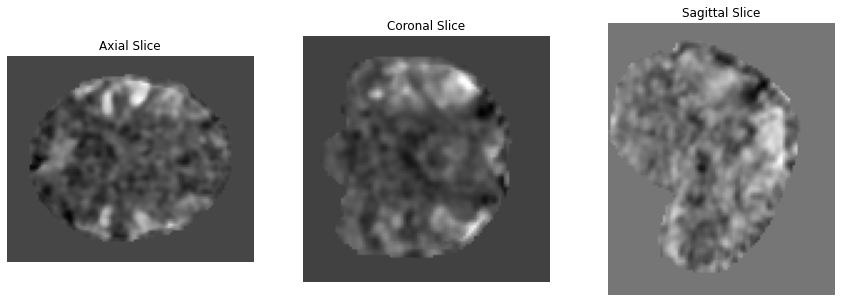

In [4]:
selected_ic = ic_extract(sica['melodic_IC'],config.sic_candidate)
plot_3d(selected_ic)

In [5]:
def calculate_lateralization_index_from_IC(IC_matrix):
# Ensure the input is of the correct shape
    if IC_matrix.shape != (91, 109, 91):
        raise ValueError("IC_matrix must be of shape (91, 109, 91)")

    # Define the ACPC plane (mid-sagittal plane)
    mid_plane_index = 45  # This is the zero-based index for the mid-sagittal plane

    left_voxels = []
    right_voxels = []
    
    # Extract mirroring voxels from both sides of the brain
    for x in range(mid_plane_index):
        mirrored_x = IC_matrix.shape[0] - 1 - x  # Find the mirroring voxel
        left_voxels.append(IC_matrix[x, :, :])
        right_voxels.append(IC_matrix[mirrored_x, :, :])
    
    # Flatten the voxel arrays
    left_voxels = np.array(left_voxels).flatten()
    right_voxels = np.array(right_voxels).flatten()
    
    # Calculate Pearson's correlation coefficient (symmetricity)
    correlation, _ = pearsonr(left_voxels, right_voxels)
    
    # Calculate mean and standard deviation of symmetricity
    symmetricities = [correlation]  # In a more complex scenario, you might have multiple ICs
    mean_symmetricity = np.mean(symmetricities)
    std_symmetricity = np.std(symmetricities)
    
    # Determine cut-off for symmetricity
    cutoff = mean_symmetricity - std_symmetricity
    
    # Filter out components with symmetricity greater than the cut-off
    if correlation <= cutoff:
        # Calculate Lateralization Index (LI)
        LI = (np.sum(left_voxels) - np.sum(right_voxels)) / (np.sum(left_voxels) + np.sum(right_voxels))
        return {"Lateralization Index": LI, "Symmetricity": correlation}
    else:
        return {"Lateralization Index": None, "Symmetricity": correlation}

result = calculate_lateralization_index_from_IC(selected_ic)
print("Lateralization Index:", result["Lateralization Index"])
print("Symmetricity:", result["Symmetricity"])

Lateralization Index: 0.24604786124591937
Symmetricity: 0.4767858717401625



criterion indices: [(14, 57, 54)]
XYZ coordinates:   [(77, 58, 55)]
MNI coordinates:   [(62.0, -12.0, 36.0)]


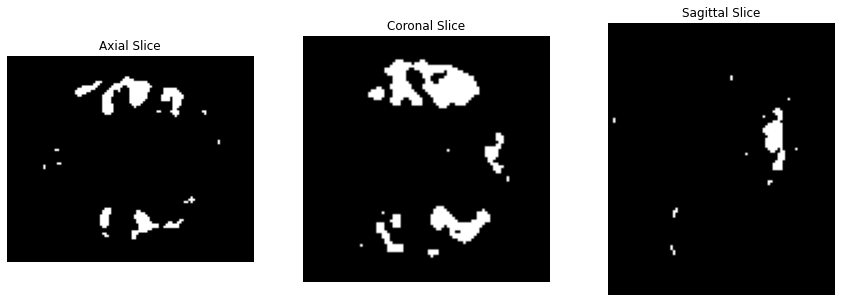

In [6]:
indices, selected_ic_cluster = ic_browse(selected_ic = selected_ic,
                                         criterion   = selected_ic >= 3.1,
                                         affine      = sica['melodic_IC'].affine,
                                         show        = False)

max_value, _ = ic_browse(selected_ic = selected_ic,
                         criterion   = selected_ic >= selected_ic.max(),
                         affine      = sica['melodic_IC'].affine,
                         show        = True)

plot_3d(selected_ic_cluster)

In [20]:
import numpy as np
from scipy.stats import pearsonr

def binary_lateralization(IC_matrix, mask=None):
    # Ensure the input is of the correct shape
    if IC_matrix.shape != (91, 109, 91):
        raise ValueError("IC_matrix must be of shape (91, 109, 91)")
    
    if mask is not None and mask.shape != IC_matrix.shape:
        raise ValueError("Mask must be of the same shape as IC_matrix")

    # Define the ACPC plane (mid-sagittal plane)
    mid_plane_index = 45  # This is the zero-based index for the mid-sagittal plane

    left_voxels = []
    right_voxels = []
    
    left_binary_lateralized = 0
    right_binary_lateralized = 0
    total_binary_voxels = 0
    
    # Extract mirroring voxels from both sides of the brain
    for x in range(mid_plane_index):
        mirrored_x = IC_matrix.shape[0] - 1 - x  # Find the mirroring voxel
        left_voxels_slice = IC_matrix[x, :, :]
        right_voxels_slice = IC_matrix[mirrored_x, :, :]

        if mask is not None:
            # Apply mask
            left_voxels_slice = left_voxels_slice[mask[x, :, :] > 0]
            right_voxels_slice = right_voxels_slice[mask[mirrored_x, :, :] > 0]
        
        left_voxels.append(left_voxels_slice)
        right_voxels.append(right_voxels_slice)

        # Binary lateralization check
        left_voxels_binary = (left_voxels_slice > 0).astype(int)
        right_voxels_binary = (right_voxels_slice > 0).astype(int)
        
        # Update binary lateralization count
        left_binary_lateralized += np.sum(left_voxels_binary & (right_voxels_binary == 0))
        right_binary_lateralized += np.sum(right_voxels_binary & (left_voxels_binary == 0))
        total_binary_voxels += np.sum(left_voxels_binary | right_voxels_binary)
    
    # Flatten the voxel arrays
    left_voxels = np.concatenate(left_voxels)
    right_voxels = np.concatenate(right_voxels)
    
    # Calculate Binary Lateralization Index (LI_binary)
    if total_binary_voxels > 0:
        left_LI_binary = left_binary_lateralized / total_binary_voxels
        right_LI_binary = right_binary_lateralized / total_binary_voxels
        LI_binary = (left_binary_lateralized+right_binary_lateralized) / total_binary_voxels
    else:
        LI_binary = None

    return {
        "Left Binary Lateralization": left_LI_binary,
        "Right Binary Lateralization": right_LI_binary,
        "Binary Lateralization Index": LI_binary
    }

result = binary_lateralization(selected_ic_cluster)
print("Left Binary Lateralization:", result["Left Binary Lateralization"])
print("Right Binary Lateralization:", result["Right Binary Lateralization"])
print("Binary Lateralization Index:", result["Binary Lateralization Index"])


Left Binary Lateralization: 0.6538461538461539
Right Binary Lateralization: 0.15848806366047746
Binary Lateralization Index: 0.8123342175066313


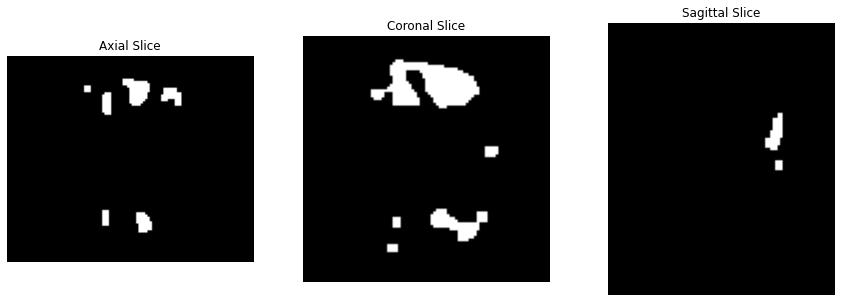

In [21]:
selected_ic_cluster = morphological_operation(selected_ic_cluster)
plot_3d(selected_ic_cluster)

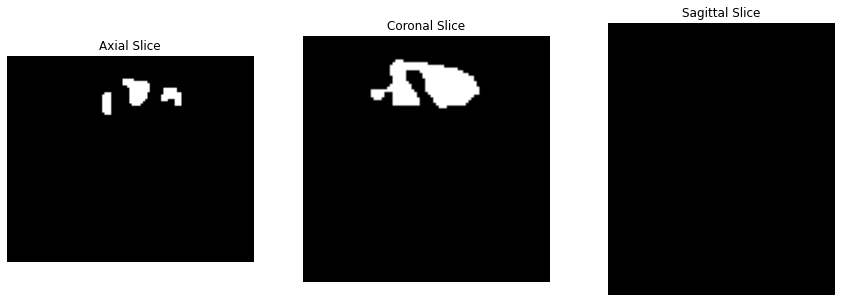

In [8]:
selected_ic_mask = mask_cc_around_coordinate(selected_ic_cluster, max_value[0])
plot_3d(selected_ic_mask)

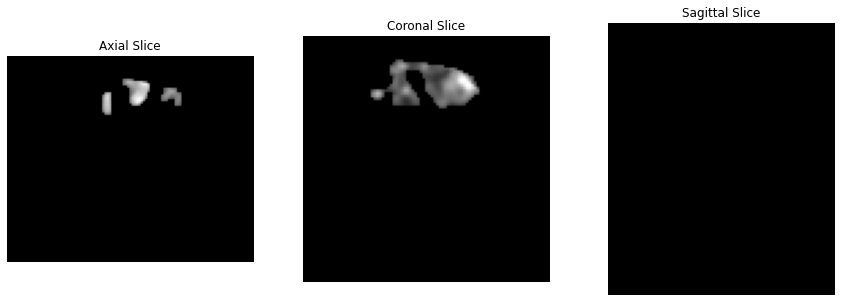

In [9]:
selected_ic_masked = selected_ic_mask * selected_ic
plot_3d(selected_ic_masked)

In [10]:
selected_ic_fMRI = np.expand_dims(selected_ic_mask, axis=-1) * bold['filtered_func_data'].get_fdata()

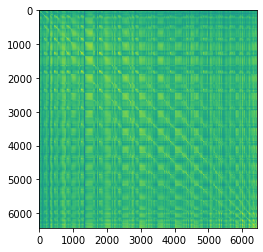

In [22]:
connectivity_matrix = cluster_connectivity(bold['filtered_func_data'].get_fdata(), selected_ic_mask)
plt.imshow(connectivity_matrix)

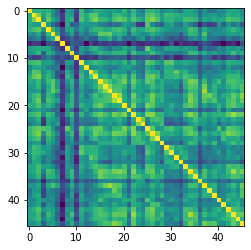

In [23]:
connectivity_matrix = cluster_connectivity_ds(bold['filtered_func_data'].get_fdata(), selected_ic_mask, downsample_factor=5)
plt.imshow(connectivity_matrix)

# Topological Measures

In [27]:
import numpy as np
import networkx as nx

from bct import clustering_coef_bu

def calculate_clustering_coefficients(connectivity_matrix, random_matrices):
    # Local Clustering Coefficient
    G = nx.from_numpy_array(connectivity_matrix)
    local_clustering = clustering_coef_bu(connectivity_matrix)
    absolute_clustering_coefficient = np.mean(local_clustering)
    
    # Normalized Clustering Coefficient
    random_clustering_coeffs = []
    for random_matrix in random_matrices:
        random_clustering = clustering_coef_bu(random_matrix)
        random_clustering_coeffs.append(np.mean(random_clustering))
    Crandom = np.mean(random_clustering_coeffs)
    normalized_clustering_coefficient = absolute_clustering_coefficient / Crandom
    
    return absolute_clustering_coefficient, normalized_clustering_coefficient

from bct import distance_bin

def calculate_characteristic_path_length(connectivity_matrix, random_matrices):
    D = distance_bin(connectivity_matrix)
    L = np.mean(D[np.isfinite(D)])
    
    random_path_lengths = []
    for random_matrix in random_matrices:
        D_random = distance_bin(random_matrix)
        L_random = np.mean(D_random[np.isfinite(D_random)])
        random_path_lengths.append(L_random)
    Lrandom = np.mean(random_path_lengths)
    normalized_path_length = L / Lrandom
    
    return L, normalized_path_length

def calculate_small_world_index(gamma, lambda_):
    sigma = gamma / lambda_
    return sigma

from bct import efficiency_bin

def calculate_efficiency_measures(connectivity_matrix):
    local_efficiency = np.mean(efficiency_bin(connectivity_matrix, local=True))
    global_efficiency = efficiency_bin(connectivity_matrix, local=False)
    
    return local_efficiency, global_efficiency

def calculate_connectivity_strength(connectivity_matrix):
    strength = np.mean(connectivity_matrix[np.triu_indices_from(connectivity_matrix, k=1)])
    return strength

def calculate_connectivity_diversity(connectivity_matrix):
    N = connectivity_matrix.shape[0]
    mean_pairwise_correlations = np.mean(connectivity_matrix, axis=1)
    connectivity_diversity = np.var(connectivity_matrix - mean_pairwise_correlations[:, None], axis=1)
    average_connectivity_diversity = np.mean(connectivity_diversity)
    
    return average_connectivity_diversity

def calculate_betweenness_centrality(connectivity_matrix, hippocampal_nodes):
    G = nx.from_numpy_array(connectivity_matrix)
    betweenness = nx.betweenness_centrality(G, normalized=True)
    
    bc_left = betweenness[hippocampal_nodes['LH']]
    bc_right = betweenness[hippocampal_nodes['RH']]
    
    return bc_left, bc_right

def compute_topological_measures(connectivity_matrix, random_matrices, hippocampal_nodes):
    # 1. Clustering Coefficients
    C, gamma = calculate_clustering_coefficients(connectivity_matrix, random_matrices)
    
    # 2. Characteristic Path Length
    L, lambda_ = calculate_characteristic_path_length(connectivity_matrix, random_matrices)
    
    # 3. Small-World Index
    sigma = calculate_small_world_index(gamma, lambda_)
    
    # 4. Efficiency Measures
    local_efficiency, global_efficiency = calculate_efficiency_measures(connectivity_matrix)
    
    # 5. Connectivity Strength
    CS = calculate_connectivity_strength(connectivity_matrix)
    
    # 6. Connectivity Diversity
    CD = calculate_connectivity_diversity(connectivity_matrix)
    
    # 7. Betweenness Centrality
    bc_left, bc_right = calculate_betweenness_centrality(connectivity_matrix, hippocampal_nodes)
    
    return {
        'Clustering Coefficient': C,
        'Normalized Clustering Coefficient (gamma)': gamma,
        'Characteristic Path Length': L,
        'Normalized Characteristic Path Length (lambda)': lambda_,
        'Small-World Index (sigma)': sigma,
        'Local Efficiency': local_efficiency,
        'Global Efficiency': global_efficiency,
        'Connectivity Strength': CS,
        'Connectivity Diversity': CD,
        'Betweenness Centrality (Left Hippocampus)': bc_left,
        'Betweenness Centrality (Right Hippocampus)': bc_right,
    }


In [28]:
def generate_random_matrices(connectivity_matrix, num_random_matrices=500):
    random_matrices = []
    for _ in range(num_random_matrices):
        random_matrix = np.random.permutation(connectivity_matrix.flatten()).reshape(connectivity_matrix.shape)
        random_matrices.append(random_matrix)
    return random_matrices

In [30]:
random_matrices = generate_random_matrices(connectivity_matrix, num_random_matrices=500)
hippocampal_nodes = {'LH': 0, 'RH': 1}  # Indices for left and right hippocampus
results = compute_topological_measures(connectivity_matrix, random_matrices, hippocampal_nodes)
for measure, value in results.items():
    print(f"{measure}: {round(value,3)}")

Clustering Coefficient: 0.521
Normalized Clustering Coefficient (gamma): 1.0
Characteristic Path Length: 0.978
Normalized Characteristic Path Length (lambda): 1.0
Small-World Index (sigma): 1.0
Local Efficiency: 1.0
Global Efficiency: 1.0
Connectivity Strength: 0.499
Connectivity Diversity: 0.023
Betweenness Centrality (Left Hippocampus): 0.0
Betweenness Centrality (Right Hippocampus): 0.0
